# Face Mask Detector

## Importing Necessary Libraries

In [45]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision import models
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix
from sklearn.model_selection import train_test_split
import wandb
%matplotlib inline

## Importing Dataset

In [46]:


wandb.init(project="FaceMaskDetector.ipynb", entity="akhil007")

wandb.config = {
  "learning_rate": 0.01,
  "epochs": 4,
  "batch_size": 64
}

accuracy,▁▇█▇█▇████████▇██
loss,█▂▂▂▂▂▂▂▂▁▂▂▂▁▄▁▁
precision,▁▇█▇█▇████████▇██
accuracy,0.9776
loss,0.05843
precision,0.9776


In [47]:
# Transforms to apply on the dataset.
# We are resizing the image to (224,224) followed by random horizontal flip and converting image to tensors
tfms = tt.Compose([
    tt.Resize((224,224)),
    tt.RandomHorizontalFlip(),
    tt.ToTensor()
])

In [48]:

# Importing the Dataset from folder RMDFDATA2, the images in the original dataset were used to create new images with blur, noise, and rotation of the image
d = ImageFolder('RMDFDATA2',transform=tfms)

In [49]:
d

Dataset ImageFolder
    Number of datapoints: 9016
    Root location: RMDFDATA2
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [50]:
classes = d.class_to_idx
classes

{'face': 0, 'mask': 1}

face means the person in the image is not wearing a mask.

## Example of the dataset

In [51]:
image,label = d[2500]
print('Image Size:',image.shape)
print('Label:',d.classes[label])
datasetLabels = d.class_to_idx

Image Size: torch.Size([3, 224, 224])
Label: face


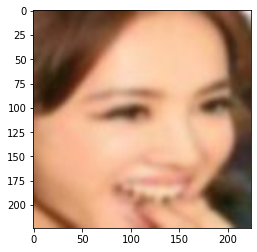

In [52]:
plt.imshow(image.permute(1,2,0))

# Data Loader

Below code is used to make sure that the training and validation sets contain equal amount of both the classes

In [53]:
targets = d.targets

In [54]:
train_idx, valid_idx= train_test_split(np.arange(len(targets)),test_size=0.2,shuffle=True,stratify=targets)

In [55]:
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

In [56]:
batch_size = 64

In [57]:
trainDL = DataLoader(d,batch_size=batch_size,pin_memory=True,sampler=train_sampler)
valDL = DataLoader(d,batch_size=batch_size*2,pin_memory=True,sampler=valid_sampler)

Let's see the distribution of classes in train and validation set

In [58]:
mask = 0
face = 0
for i in trainDL:
    image,label = i
    for l in label:
        if d.classes[l]=='mask':
            mask+=1
        else:
            face+=1
print('Face Label Images in Train Set:',face)
print('Mask Label Images in Train Set:',mask)

Face Label Images in Train Set: 3688
Mask Label Images in Train Set: 3524


In [59]:
mask = 0
face = 0
for i in valDL:
    image,label = i
    for l in label:
        if d.classes[l]=='mask':
            mask+=1
        else:
            face+=1
print('Face Label Images in Validation Set:',face)
print('Mask Label Images in Validation Set:',mask)

Face Label Images in Validation Set: 922
Mask Label Images in Validation Set: 882


As we can see, the class labels are almost equally distributed amongst train and test sets

# Move to GPU Code

Below code is used to make sure that the model and the data is transferred to a cuda graphics card if available, else RAM

In [60]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# Custom Data Loader which transfers the data to cuda graphics card, or RAM whichever available, and then returns the data
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [61]:
device = get_default_device()
trainDL = DeviceDataLoader(trainDL,device)
valDL = DeviceDataLoader(valDL,device)

# Model 

We will try to make a simple CNN model instead of using pre trained ones

In [62]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
                                    nn.Conv2d(3,8,(3,3),stride=1,padding=1), # 3x224x224 => 8x224x224
                                    nn.ReLU(),
                                    nn.MaxPool2d(2,2),
                                    nn.Conv2d(8,64,(3,3),padding=1),# 8x112x112 => 64x112x112
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2,2),
                                    nn.Conv2d(64,128,(3,3),padding=1),# 64x56x56 => 128x56x56
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2,2), # 128x56x56 => 128x24x24
                                    nn.AdaptiveAvgPool2d(output_size=(6,6)),
                                    nn.Flatten()
                                    )
        
        self.linear = nn.Sequential( nn.Linear(4608,2048,bias=True),
                                    nn.Dropout(0.5),
                                    nn.ReLU(),
                                    nn.Linear(2048,100,bias=True),
                                    nn.Dropout(0.5),
                                    nn.ReLU(),
                                    nn.Linear(100,2,bias=True))
        
        
    def training_step(self,batch):
        image,label = batch
        out = self(image)
        loss = F.cross_entropy(out,label)
        return loss
    
    
    def forward(self,batch):
        out = self.network(batch)
        out = self.linear(out)
        return out
    
    
    def validation_step(self,batch):
        image,label = batch
        out = self(image)
        loss = F.cross_entropy(out,label)
        _, y_pred = torch.max(out,dim=1)
        label = label.cpu().numpy()
        y_pred = y_pred.detach().cpu().numpy()
        accuracy = accuracy_score(label,y_pred)
        precision = recall_score(label,y_pred,average='micro')
        print('Confusion Matrix for Evaluation:')
        print(confusion_matrix(label,y_pred))
        return {'val_loss':loss.detach(),'val_accuracy':torch.Tensor([accuracy]),'precision':torch.Tensor([precision])}
    
    
    def validation_epoch_end(self,outputs):
        val_loss = [x['val_loss'] for x in outputs]
        val_loss_n = torch.stack(val_loss).mean()
        val_score = [x['val_accuracy'] for x in outputs]
        val_score_n = torch.stack(val_score).mean()
        precision = [x['precision'] for x in outputs]
        precision = torch.stack(precision).mean().item()
        wandb.log({'accuracy': val_score_n, 'loss': val_loss_n, 'precision':precision})
        return {'val_loss':val_loss_n,'val_score':val_score_n,'precision':precision}

    
    
    def epoch_end(self,epoch,result):
        print('Epoch {}: train_loss: {:.4f} val_loss: {:.4f} val_score: {:.4f} precision: {}'.format(epoch,result['train_loss'],result['val_loss'],result['val_score'],result['precision']))

## Defining the fit, evaluate functions and training the Neural Network

In [63]:
model = CNN()
model.to(device)

CNN(
  (network): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): AdaptiveAvgPool2d(output_size=(6, 6))
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (linear): Sequential(
    (0): Linear(in_features=4608, out_features=2048, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=2

In [64]:
@torch.no_grad()
def evaluate():
    model.eval()
    result = [model.validation_step(batch) for batch in valDL]
    return model.validation_epoch_end(result)

def fit(num_epochs, lr, opt_func, grad_clip=None):
    history=[]
    torch.cuda.empty_cache()
    optimizer = opt_func(model.parameters(),lr,weight_decay=1e-4)
    for i in range(num_epochs):
        torch.cuda.empty_cache()
        model.train()
        train_loss=[]
        for data in trainDL:
            loss = model.training_step(data)
            train_loss.append(loss)
            loss.backward()
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate()
        result['train_loss'] = torch.stack(train_loss).mean().item()
        model.epoch_end(i,result)
        history.append(result)
    return history

def fitall(num_epochs, lr, opt_func, grad_clip=None):
    history=[]
    torch.cuda.empty_cache()
    optimizer = opt_func(model.parameters(),lr,weight_decay=1e-3)
    for i in range(num_epochs):
        torch.cuda.empty_cache()
        model.train()
        train_loss=[]
        for data in trainDL:
            loss = model.training_step(data)
            train_loss.append(loss)
            loss.backward()
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
        torch.cuda.empty_cache()
        for data in valDL:
            loss = model.training_step(data)
            train_loss.append(loss)
            loss.backward()
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
#         result = evaluate()
#         result['train_loss'] = torch.stack(train_loss).mean().item()
#         model.epoch_end(i,result)
#         history.append(result)
    return history


In [65]:
torch.cuda.empty_cache()

## Lets check the accuracy of our neural network 

In [66]:
evaluate()

Confusion Matrix for Evaluation:
[[69  0]
 [59  0]]
Confusion Matrix for Evaluation:
[[69  0]
 [59  0]]
Confusion Matrix for Evaluation:
[[68  0]
 [60  0]]
Confusion Matrix for Evaluation:
[[64  0]
 [64  0]]
Confusion Matrix for Evaluation:
[[59  0]
 [69  0]]
Confusion Matrix for Evaluation:
[[67  0]
 [61  0]]
Confusion Matrix for Evaluation:
[[74  0]
 [54  0]]
Confusion Matrix for Evaluation:
[[60  0]
 [68  0]]
Confusion Matrix for Evaluation:
[[65  0]
 [63  0]]
Confusion Matrix for Evaluation:
[[66  0]
 [62  0]]
Confusion Matrix for Evaluation:
[[60  0]
 [68  0]]
Confusion Matrix for Evaluation:
[[57  0]
 [71  0]]
Confusion Matrix for Evaluation:
[[68  0]
 [60  0]]
Confusion Matrix for Evaluation:
[[72  0]
 [56  0]]
Confusion Matrix for Evaluation:
[[4 0]
 [8 0]]


{'val_loss': tensor(0.6932, device='cuda:0'),
 'val_score': tensor(0.5003),
 'precision': 0.5003471970558167}

Without any training, our neural network has an accuracy of 50% with a precision of 50% as well, although we can see from the confusion matrix that our neural network fails to recognize any data of class 0.  

Let's Train it Now!!

In [67]:
hist = []

In [68]:
epochs = 14
lr = 0.01
optim = torch.optim.SGD
grad_clip = 0.1

In [69]:
hist+=fit(epochs,lr,optim,grad_clip)

Confusion Matrix for Evaluation:
[[67  4]
 [ 3 54]]
Confusion Matrix for Evaluation:
[[64  7]
 [ 5 52]]
Confusion Matrix for Evaluation:
[[55  1]
 [ 9 63]]
Confusion Matrix for Evaluation:
[[70  4]
 [ 2 52]]
Confusion Matrix for Evaluation:
[[62  6]
 [ 3 57]]
Confusion Matrix for Evaluation:
[[46  6]
 [ 6 70]]
Confusion Matrix for Evaluation:
[[55  6]
 [ 5 62]]
Confusion Matrix for Evaluation:
[[56  5]
 [ 9 58]]
Confusion Matrix for Evaluation:
[[52  8]
 [ 7 61]]
Confusion Matrix for Evaluation:
[[64  3]
 [ 3 58]]
Confusion Matrix for Evaluation:
[[65  7]
 [ 4 52]]
Confusion Matrix for Evaluation:
[[60 11]
 [ 2 55]]
Confusion Matrix for Evaluation:
[[60  1]
 [ 5 62]]
Confusion Matrix for Evaluation:
[[70  4]
 [ 3 51]]
Confusion Matrix for Evaluation:
[[3 0]
 [0 9]]
Epoch 0: train_loss: 0.3796 val_loss: 0.1977 val_score: 0.9276 precision: 0.9276041388511658
Confusion Matrix for Evaluation:
[[46 11]
 [ 4 67]]
Confusion Matrix for Evaluation:
[[53 10]
 [ 1 64]]
Confusion Matrix for Evalua

In [70]:
epochs = 7

In [71]:
hist+=fit(epochs,lr,optim,grad_clip)

Confusion Matrix for Evaluation:
[[71  1]
 [ 3 53]]
Confusion Matrix for Evaluation:
[[61  0]
 [ 4 63]]
Confusion Matrix for Evaluation:
[[66  1]
 [ 8 53]]
Confusion Matrix for Evaluation:
[[64  0]
 [ 2 62]]
Confusion Matrix for Evaluation:
[[67  2]
 [ 6 53]]
Confusion Matrix for Evaluation:
[[63  0]
 [ 5 60]]
Confusion Matrix for Evaluation:
[[55  0]
 [ 5 68]]
Confusion Matrix for Evaluation:
[[73  0]
 [ 2 53]]
Confusion Matrix for Evaluation:
[[60  1]
 [ 5 62]]
Confusion Matrix for Evaluation:
[[71  0]
 [ 7 50]]
Confusion Matrix for Evaluation:
[[66  0]
 [ 5 57]]
Confusion Matrix for Evaluation:
[[64  1]
 [ 4 59]]
Confusion Matrix for Evaluation:
[[68  0]
 [ 7 53]]
Confusion Matrix for Evaluation:
[[63  0]
 [ 5 60]]
Confusion Matrix for Evaluation:
[[4 0]
 [2 6]]
Epoch 0: train_loss: 0.0772 val_loss: 0.1269 val_score: 0.9503 precision: 0.9503472447395325
Confusion Matrix for Evaluation:
[[62  1]
 [ 5 60]]
Confusion Matrix for Evaluation:
[[63  0]
 [ 4 61]]
Confusion Matrix for Evalua

In [72]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in hist]
    val_losses = [x['val_loss'] for x in hist]
    plt.plot(train_losses, '-bx')
    #plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

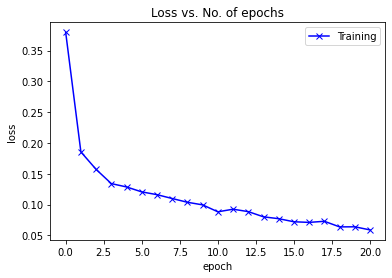

In [73]:
plot_losses(hist)

In [74]:
def plot_accuracies(history):
    accuracies = [x['val_score'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

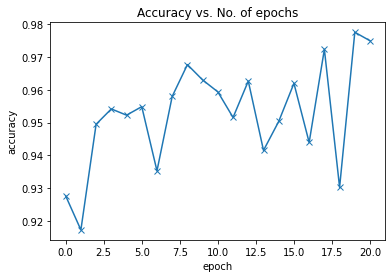

In [75]:
plot_accuracies(hist)

## Testing the Model on some images

In [76]:
test_data = ImageFolder('test_data',transform=tt.ToTensor())
# plt.imshow(test_data[4][0].permute(1,2,0))
# # test_data[0]

In [77]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    model.eval()
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    print(yb.detach())
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return d.classes[preds[0].item()]


tensor([[-5.3678,  4.8843]], device='cuda:0')
Predicted: mask


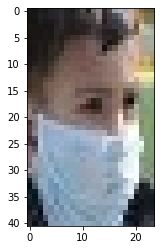

In [78]:
img, label = test_data[0]
plt.imshow(img.permute(1, 2, 0))
print('Predicted:', predict_image(img, model))

tensor([[-4.2653,  3.7920]], device='cuda:0')
Predicted: mask


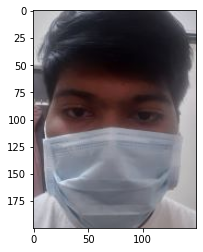

In [79]:
img, label = test_data[1]
plt.imshow(img.permute(1, 2, 0))
print('Predicted:', predict_image(img, model))

tensor([[-4.2947,  3.8385]], device='cuda:0')
Predicted: mask


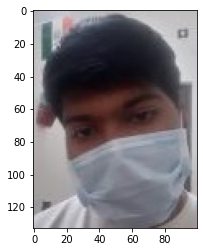

In [80]:
img, label = test_data[2]
plt.imshow(img.permute(1, 2, 0))
print('Predicted:', predict_image(img, model))

tensor([[ 1.8755, -1.6574]], device='cuda:0')
Predicted: face


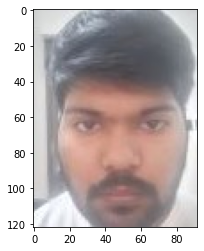

In [81]:
img, label = test_data[3]
plt.imshow(img.permute(1, 2, 0))
print('Predicted:', predict_image(img, model))

tensor([[ 2.3169, -2.0112]], device='cuda:0')
Predicted: face


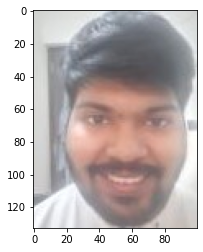

In [82]:
img, label = test_data[4]
plt.imshow(img.permute(1, 2, 0))
print('Predicted:', predict_image(img, model))

tensor([[-5.8824,  5.3574]], device='cuda:0')
Predicted: mask


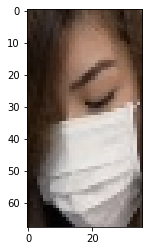

In [83]:
img, label = test_data[5]
plt.imshow(img.permute(1, 2, 0))
print('Predicted:', predict_image(img, model))

In [84]:
torch.save(model.state_dict(), 'mask_best_model.pth')